# Project 2: Continuous Control

---

### 1. Start the Environment

We begin by importing some necessary packages.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import sys
import matplotlib.pyplot as plt
import time

%matplotlib inline

Unity environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
env = UnityEnvironment(file_name = 'Reacher.exe')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

The next cell shows the performance of a random agent and the commands needed to interact with the Unity environment.

Even though there are 20 separate agents, each episode is a fixed length of 1001 steps. Therefore, all agents reach a terminal state at the same time, which simplifies how we track scores.

In [4]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
steps = 0
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    steps += 1
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode ({} steps total): {:.2f}'.format(steps, np.mean(scores)))

Total score (averaged over agents) this episode (1001 steps total): 0.20


### 4. Solving the Environment

Next we implement Proximal Policy Optimization (PPO) to solve the environment.

When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

First, we import additional packages.

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
from collections import deque
import sys
import time
import pandas as pd

In [ ]:
%load_ext autoreload
%autoreload 2

The PPO agent and network architecture for the agent are included in the PPO_agent.py file.

In [17]:
from PPO_agent import PPOAgent

Next, we define our training function, which terminates once an agent has solved the environment (when the average score for the last 100 episodes was >= 30). For this project, each epsiode was allowed to continue until terminated by the environment - no limit on the number steps was imposed.

In [18]:
def train(env, agent, n_episodes = 10000, n_workers = 20,
          evaluation_window = 100, verbose = 100, solved_score = 30):
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    agent.model.to(device)

    agent.reset_current_step()
    scores = []
    
    for i in range(n_episodes):
        total_rewards = np.zeros(n_workers)
    
        env_info = env.reset(train_mode = True)[brain_name]
        state = env_info.vector_observations
        while True:
            action = agent.action(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            reward = np.array(env_info.rewards)
            done = np.array(env_info.local_done)

            total_rewards += reward

            agent.update(state, action, reward, next_state, done)

            if np.any(done):
                break

            state = next_state
        
        scores.append(total_rewards)
        
        average_score = np.mean(np.mean(scores, axis = 1)[-min(evaluation_window, i + 1):])
        current_score = np.mean(scores, axis = 1)[-1]
        print('\rEpisode {} | Score: {:.2f} | Average Score: {:.2f}'.format(i + 1, current_score, average_score), end = '')
        sys.stdout.flush()
        if (i + 1) % verbose == 0:
            print('')
            
        if average_score > solved_score:
            print('\nEnvironment solved in {} episodes'.format(i + 1))
            break
    
    return scores

Here, we instantiate our agent and define its hyperparameters. 

The first arguments set the dimensions of the state and action space. We then use separate networks for the policy and value approximations; there are no shared layers, so we can set the value_weight argument to 1.0. In this model architecture, the policy is output as a multivariate normal distribution with a spherical covariance (all entries to the covariance matrix are 0 except along the diagonal). While the mean of this distribution is dependent on the state, the covariance matrix is not - it is a separate learned parameter that has no hidden layers. The mean is modeled by a tanh output layer, to ensure the mean is between -1 and 1, and the covariance matrix is modeled with the softplus function, to ensure that the covariance matrix is positive semi-definite. Finally, all actions are clipped to be between -1 and 1.

Similar to the advantage function used by the original authors of PPO, we use a truncated version of generalized advantage estimation (reference in the README section), with a lambda of 0.95. We also used the clipped variant of PPO with an epsilon of 0.1, clipping the surrogate objective between 0.9 and 1.1. Lastly, we use a step size of 256, for a total of 5,120 observations for each update step. We ran through these observations for 10 epochs with a minibatch size of 256.

We applied entropy regularization to encourage exploration in the policy, setting the entropy beta parameter to 0.01. More aggressive regularization (higher betas) lead to policies with higher variance that took longer to solve the environment or became stuck at a lower score. Less regularization lead to policies with very little variance that did not explore enough and quickly became too certain (overfit the environment) and never solved the environment. The level of regularization chosen was closely tied to network size as larger, more expressive networks required more regularization to avoid overfitting.

The full set of hyperparameters are listed below.

Finally, we train the agent! We train 5 separate agents with the same hyperparameters and graph each agent's performance to see the variation that occurs during training. Each agent is given 500 episodes to solve the environment. However, with the selected hyperparameters, most agents solved the environment within 300 episodes.

In [57]:
print('PPO')
ppo_scores = []
for i in range(5):
    print('Run', i + 1)
    
    agent = PPOAgent(33, 4, 
                 shared_hidden_layers = tuple(),
                 value_hidden_layers = (256, 128),
                 policy_hidden_layers = (256, 128),
                 n_workers = 20,
                 n_steps = 256,
                 n_epochs = 10,
                 n_batches = 20,
                 clip_epsilon = 0.1,
                 gamma = 0.99,
                 value_weight = 1.0,
                 entropy_beta = 1e-2,
                 use_gae = True,
                 gae_lambda = 0.95,
                 normalize_adv = True,
                 optimizer = optim.Adam,
                 learning_rate = 1e-4,
                 l2_regularization = 0.0,
                 gradient_clipping = 10.0)
    
    t = time.time()
    scores = train(env, agent, n_episodes = 500, verbose = 100)
    print('Wall time:', (time.time() - t) / 60.0, '\n')
    ppo_scores.append(scores)

PPO
Run 1
Episode 100 | Score: 27.18 | Average Score: 13.21
Episode 169 | Score: 34.65 | Average Score: 30.00
Environment solved in 169 episodes
Wall time: 36.22304440736771 

Run 2
Episode 100 | Score: 15.53 | Average Score: 6.17
Episode 200 | Score: 34.77 | Average Score: 28.11
Episode 211 | Score: 35.31 | Average Score: 30.01
Environment solved in 211 episodes
Wall time: 43.196095538139346 

Run 3
Episode 100 | Score: 9.17 | Average Score: 3.24
Episode 200 | Score: 32.14 | Average Score: 20.22
Episode 249 | Score: 33.90 | Average Score: 30.13
Environment solved in 249 episodes
Wall time: 63.54345144033432 

Run 4
Episode 100 | Score: 18.09 | Average Score: 8.29
Episode 200 | Score: 31.69 | Average Score: 28.83
Episode 213 | Score: 33.17 | Average Score: 30.10
Environment solved in 213 episodes
Wall time: 53.916774622599284 

Run 5
Episode 100 | Score: 18.89 | Average Score: 9.94
Episode 200 | Score: 25.64 | Average Score: 22.81
Episode 300 | Score: 30.90 | Average Score: 27.96
Episo

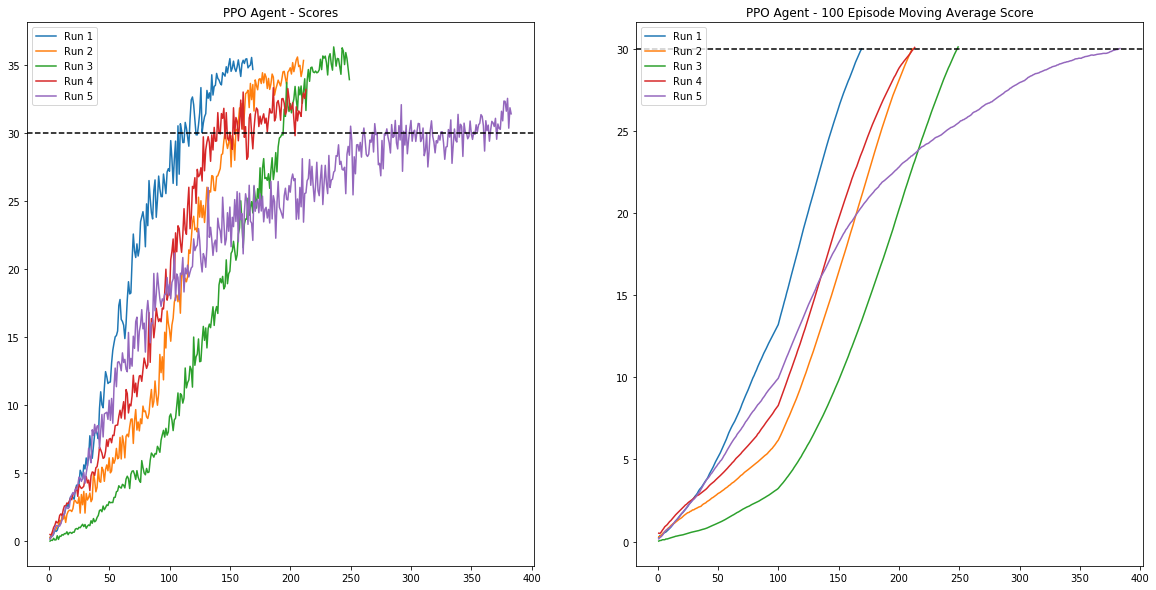

In [62]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10))

for i, s in enumerate(ppo_scores):
    average_scores = np.mean(s, axis = 1)
    ax[0].plot(np.arange(len(average_scores)) + 1, average_scores, label = 'Run ' + str(i + 1))
    
    running_avg_scores = pd.Series(average_scores).rolling(100, min_periods = 1).mean()
    ax[1].plot(np.arange(len(running_avg_scores)) + 1, running_avg_scores, label = 'Run ' + str(i + 1))

ax[0].axhline(30.0, color = 'k', linestyle = '--')
ax[1].axhline(30.0, color = 'k', linestyle = '--')
ax[0].legend(loc = 'upper left')
ax[0].set_title('PPO Agent - Scores')
ax[1].legend(loc = 'upper left')
ax[1].set_title('PPO Agent - 100 Episode Moving Average Score')
plt.show()

As can be seen in the graphs above, there is quite a bit of variation in the number of episodes required to solve the environment. Other hyperparameter settings led to agents that could solve the environment quicker, but less reliably. This combination provided a good balance of training speed and reliability and proved to be very robust to the stochasticity in the environment and the agent's actions.

Lastly, we save the weights and biases of the last PPO agent and close the environment.

In [63]:
torch.save(agent.model.state_dict(), 'PPOAgent.pt')
env.close()

### 5. Ideas for Future Work

There are multiple other algorithms that allow for continuous policies that can undoubtedly solve this environment, including DDPG and A2C/A3C. 

One interesting twist on this environment would be to only provide the pixel images that each agent/arm sees at each time step, instead of the 33-dimensional vector of positions, angles, and velocities. This would be a much more challenging problem, requiring the use of (most likely) shared CNN layers, but would reduce the need for the feature engineering included in the current environment.

While the policy network uses generalized advantage estimation to improve upon the advantage function that guides learning the policy, the critic network only estimates the mean state-value function. It would be interesting to try to learn the state-value distribution, instead of only the mean, similar to distributional approach taken in distributional DQN (e.g., Categorical DQN or C51). This could improve learning by providing a more robust state-value estimate, which is used in the estimation of the advantage function.